In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OUTPUT_EXP21_DIR = DIR + '/output/EXP021/'
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
!pip install catboost
#!pip install category_encoders
#!pip install feature_engine
#!pip install featuretools
#!pip install woodwork

import lightgbm as lgb
import xgboost as xgb
from catboost import *
import catboost as ctb
from catboost import Pool
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

from sklearn import preprocessing
#from category_encoders.target_encoder import TargetEncoder
#from feature_engine.encoding import WoEEncoder
#import featuretools as ft
#from woodwork.logical_types import Categorical

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.5 MB/s eta 0:00:00


In [5]:
v3_pred_df = pd.read_pickle(OUTPUT_EXP21_DIR+'oof_df.pkl')
v3_pred_df.rename(columns={"pred":"v3_pred"},inplace=True)
v3_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-v3-base_seed42_ver21.csv"), header=None)[1]

oof_df = pd.read_csv(os.path.join(OOF_DIR, f'oof_catboost_ver17.csv'))
oof_df.rename(columns={"pred":"oof17_pred"},inplace=True)
oof17_test = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_catboost_ver17.csv"), header=None)[1]

train = pd.read_csv(os.path.join(INPUT_DIR,"train.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test.csv"))
card = pd.read_csv(os.path.join(INPUT_DIR, "card.csv"))
user = pd.read_csv(os.path.join(INPUT_DIR, "user.csv"))
sub = pd.read_csv(os.path.join(INPUT_DIR, "sample_submit.csv"), header=None)

In [6]:
numerical_features = ["amount", "cards_issued", "credit_limit", "current_age", "retirement_age", "birth_year", "latitude", "longitude",
                      "per_capita_income_zipcode", "yearly_income_person", "total_debt", "fico_score", "num_credit_cards", "income_rate"]
categorical_features = ["user_id", "card_id", "errors?", "merchant_id", "merchant_city", "merchant_state", "mcc", "use_chip",
                        "card_brand", "card_type", "has_chip", "gender", "city", "state",
                        "birth_month",
                        ]
target = "is_fraud?"

In [7]:
train = train.merge(oof_df[["index", "oof17_pred", "fold"]], how="left", on="index").merge(v3_pred_df[["index", "v3_pred"]], how="left", on="index")
test["oof17_pred"] = oof17_test
test["v3_pred"] = v3_test

In [8]:
train["amount"] = train["amount"].astype(str).str.extract("(\d+)").astype("float32")
test["amount"] = test["amount"].astype(str).str.extract("(\d+)").astype("float32")

In [9]:
concat_data = pd.concat([train,test],axis=0)
concat_data = concat_data.merge(card, how="left", on=["user_id", "card_id"]).merge(user, how="left", on="user_id")

concat_data = concat_data.fillna("NAN")

city_c = concat_data["merchant_city"].value_counts(normalize=True).to_dict()
state_c = concat_data["merchant_state"].value_counts(normalize=True).to_dict()

concat_data["city_c"] = concat_data["merchant_city"].map(lambda x: city_c[x]).values
concat_data["state_c"] = concat_data["merchant_state"].map(lambda x: state_c[x]).values

concat_data.loc[concat_data["city_c"]<0.0005, "merchant_city"] = "Rare_city"
concat_data.loc[concat_data["state_c"]<0.0005, "merchant_state"] = "Rare_state"

def aggregation_features(df, valid_data, test_data, cat_features):
  for col in cat_features:
    oof17_agg = df.groupby(col)["oof17_pred"].agg(["mean", "std", "max", "min"])
    oof17_agg = oof17_agg.add_prefix(f'agg17_{col}_')
    oof17_agg = oof17_agg.reset_index()

    oofv3_agg = df.groupby(col)["v3_pred"].agg(["mean", "std", "max", "min"])
    oofv3_agg = oofv3_agg.add_prefix(f'aggv3_{col}_')
    oofv3_agg = oofv3_agg.reset_index()

    df = df.merge(oof17_agg, how="left", on=col).merge(oofv3_agg, how="left", on=col)
    valid_data = valid_data.merge(oof17_agg, how="left", on=col).merge(oofv3_agg, how="left", on=col)
    test_data = test_data.merge(oof17_agg, how="left", on=col).merge(oofv3_agg, how="left", on=col)
  return df, valid_data, test_data

for col in ["errors?", "merchant_city", "merchant_state", "use_chip", "card_brand", "card_type", "has_chip", "gender", "city", "state"]:
  print(col)
  le = preprocessing.LabelEncoder()
  le.fit(concat_data[col])
  concat_data[col] = le.transform(concat_data[col])

errors?
merchant_city
merchant_state
use_chip
card_brand
card_type
has_chip
gender
city
state


In [10]:
concat_data["credit_limit"] = concat_data["credit_limit"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["per_capita_income_zipcode"] = concat_data["per_capita_income_zipcode"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["yearly_income_person"] = concat_data["yearly_income_person"].astype(str).str.extract("(\d+)").astype("float32")
concat_data["total_debt"] = concat_data["total_debt"].astype(str).str.extract("(\d+)").astype("float32")

concat_data["income_rate"] = concat_data["yearly_income_person"] / concat_data["per_capita_income_zipcode"]

In [11]:
train_df = concat_data.iloc[:train.shape[0],:]
train_df = train_df.reset_index(drop=True)
test_df = concat_data.iloc[train.shape[0]:,:]
test_df = test_df.reset_index(drop=True)

In [12]:
amount_user_mean = train_df.groupby("user_id")["amount"].mean().to_dict()
train_df["amount_mean"] = train_df["user_id"].map(lambda x: amount_user_mean[x]).values
test_df["amount_mean"] = test_df["user_id"].map(lambda x: amount_user_mean[x]).values
train_df["diff_amount"] = train_df["amount"] - train_df["amount_mean"]
test_df["diff_amount"] = test_df["amount"] - test_df["amount_mean"]

In [13]:
train_df["neg_is_franud?"] = pd.Series(np.where(train_df[target]==1.0, 0.0, 1.0))
total_pos = train_df[target].sum()
total_neg = train_df["neg_is_franud?"].sum()

for col in categorical_features:
  print(col)
  if col=="merchant_id":
    continue
  pos = train_df.groupby(col)[target].sum() / total_pos
  neg = train_df.groupby(col)["neg_is_franud?"].sum() / total_neg
  woe = pos/neg
  train_df[f"{col}_woe"] = np.log(train_df[col].map(woe).astype(float))
  test_df[f"{col}_woe"] = np.log(test_df[col].map(woe).astype(float))

user_id
card_id
errors?
merchant_id
merchant_city
merchant_state
mcc


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


use_chip
card_brand
card_type
has_chip
gender
city
state
birth_month


In [14]:
train_df[target] = train_df[target].astype(float)

In [15]:
class CFG:
  debug=False
  ver=32
  model="catboost"
  n_folds=5
  trn_fold=[0, 1, 2, 3, 4]
  seed=42
  target= target
  boosting_type="gbdt"
  early_stopping_round=50
  verbose=200

In [16]:
if CFG.debug:
    display(train_df.groupby('fold').size())
    train_df = train_df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train_df.groupby('fold').size())

In [17]:
params = {
        "n_estimators":10000,
        "learning_rate":0.05,
        'depth': 5,
        "random_state":CFG.seed,
        'colsample_bylevel': 0.50,
        'subsample': 0.80,
        'l2_leaf_reg': 3,
    }

features = numerical_features + categorical_features + [f"{col}_woe" for col in categorical_features if col not in "merchant_id"] + ["amount_mean", "diff_amount"]\
+ [f"agg17_{col}_mean" for col in categorical_features] + [f"aggv3_{col}_mean" for col in categorical_features] + [f"agg17_{col}_std" for col in categorical_features] + [f"aggv3_{col}_std" for col in categorical_features] \
+ [f"agg17_{col}_max" for col in categorical_features] + [f"aggv3_{col}_max" for col in categorical_features] + [f"agg17_{col}_min" for col in categorical_features] + [f"aggv3_{col}_min" for col in categorical_features]
oof_df = pd.DataFrame()
test_preds = np.zeros(len(test_df))

for fold in range(CFG.n_folds):
  if fold in CFG.trn_fold:
    print("="*15,f" FOLD : {fold} ","="*15)
    train_folds = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_folds = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_folds, valid_folds, test_folds = aggregation_features(train_folds, valid_folds, test_df, categorical_features)

    train_X = train_folds[features]
    valid_X = valid_folds[features]
    test_X = test_folds[features]
    train_labels = train_folds[CFG.target].values
    valid_labels = valid_folds[CFG.target].values

    train_pool = Pool(train_X,
                     label=train_labels,
                      cat_features=categorical_features
                      )
    valid_pool = Pool(valid_X,
                    label=valid_labels,
                    cat_features=categorical_features
                      )

    model = ctb.CatBoostClassifier(**params)
    model.fit(train_pool,
              eval_set=[valid_pool],
              early_stopping_rounds=CFG.early_stopping_round,
              verbose=CFG.verbose,
              use_best_model=True)

    valid_folds["pred"] = model.predict_proba(valid_pool)[:, 1]
    test_preds += model.predict_proba(Pool(test_X, cat_features=categorical_features))[:, 1]
    oof_df = pd.concat([oof_df, valid_folds])

    validy_pred = np.where(valid_folds["pred"]>0.5, 1, 0)
    scoref1 =  f1_score(valid_labels, validy_pred)
    print(f"F1 Score : {scoref1}")
    del model, train_folds, valid_folds, test_folds, train_X, valid_X, test_X, train_pool, valid_pool, validy_pred

===============  FOLD : 0  ===============
0:	learn: 0.6184756	test: 0.6183128	best: 0.6183128 (0)	total: 1.36s	remaining: 3h 46m 8s
200:	learn: 0.1296260	test: 0.1309160	best: 0.1309160 (200)	total: 3m 25s	remaining: 2h 46m 48s
400:	learn: 0.1262689	test: 0.1284611	best: 0.1284406 (399)	total: 6m 22s	remaining: 2h 32m 29s
600:	learn: 0.1243011	test: 0.1272971	best: 0.1272971 (600)	total: 9m 23s	remaining: 2h 26m 53s
800:	learn: 0.1228221	test: 0.1269856	best: 0.1267703 (764)	total: 12m 25s	remaining: 2h 22m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1267702819
bestIteration = 764

Shrink model to first 765 iterations.
F1 Score : 0.6607830250680686
===============  FOLD : 1  ===============
0:	learn: 0.6181470	test: 0.6181477	best: 0.6181477 (0)	total: 687ms	remaining: 1h 54m 25s
200:	learn: 0.1290040	test: 0.1314594	best: 0.1314594 (200)	total: 3m 8s	remaining: 2h 32m 54s
400:	learn: 0.1256340	test: 0.1289246	best: 0.1289236 (399)	total: 6m 17s	remaining: 

In [18]:
f1score =  f1_score(oof_df[CFG.target], np.where(oof_df["pred"]>0.5,1,0))
print(f'CV F1 Score: {f1score}')

CV F1 Score: 0.664234669061249


In [19]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(oof_df[CFG.target], (oof_df["pred"]>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(oof_df[CFG.target], (oof_df["pred"]>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.644108659695551
F1 score at threshold 0.16 is 0.6503608660785886
F1 score at threshold 0.17 is 0.6566619465409265
F1 score at threshold 0.18 is 0.6620141658234628
F1 score at threshold 0.19 is 0.6664650375030244
F1 score at threshold 0.2 is 0.6702875203289453
F1 score at threshold 0.21 is 0.6732473185139126
F1 score at threshold 0.22 is 0.6761787772843241
F1 score at threshold 0.23 is 0.678111314595111
F1 score at threshold 0.24 is 0.6792519577417229
F1 score at threshold 0.25 is 0.6803547643026542
F1 score at threshold 0.26 is 0.6815655282100052
F1 score at threshold 0.27 is 0.6825617130960642
F1 score at threshold 0.28 is 0.6829122041407799
F1 score at threshold 0.29 is 0.6828514305875238
F1 score at threshold 0.3 is 0.6829160953976878
F1 score at threshold 0.31 is 0.6827963401543679
F1 score at threshold 0.32 is 0.6828014123615921
F1 score at threshold 0.33 is 0.6821889929459649
F1 score at threshold 0.34 is 0.6816809522157061
F1 score at threshold 0.

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


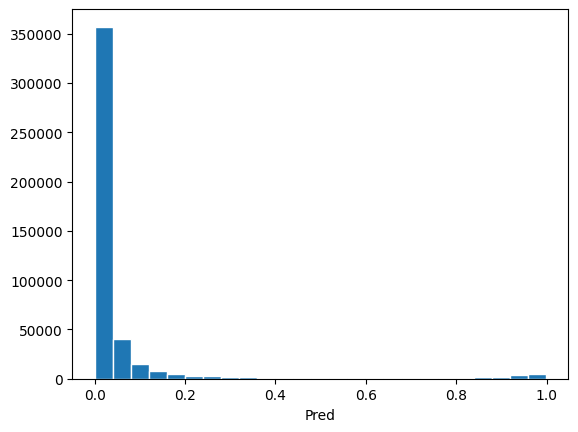

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0    432100
1     25858
Name: 1, dtype: int64


In [20]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)
print(submit[1].value_counts())

In [21]:
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')

if not os.path.exists(OOF_DIR):
    os.makedirs(OOF_DIR)

oof_df.to_csv(os.path.join(OOF_DIR, f'oof_{CFG.model}_ver{CFG.ver}.csv'))

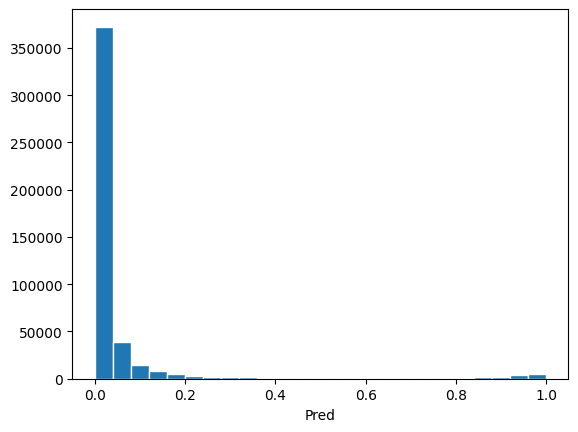

In [22]:
plt.hist(oof_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [23]:
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(SUB_NUM_DIR):
    os.makedirs(SUB_NUM_DIR)

sub_df = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_preds / CFG.n_folds
sub_df[1] = pred

sub_df.to_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(sub_df.head())

,0,1
0,471283,0.017923
1,471284,0.094596
2,471285,0.030962
3,471286,0.675691
4,471287,0.005845
